<a href="https://colab.research.google.com/github/sumedhekaru/Analysing-Student-Reviews/blob/master/Analysing_student_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Every semester, the students have the opportunity to review me using the feedback tools provided by my university, so I am a professor. I usually read every one of those to improve my teaching skills. 

Now imagine a review system that produces 100s of reviews if not 1000s of reviews on a product or service. Reading every review might be almost impossible. That's where we need machine learning techniques. Analyzing reviews are very useful to get the customer's voice and improve the product or service in the e-commerce world.

The goal here is to use ***Text Mining*** techniques to examine a collection of reviews or unstructured data and quickly understand the important points. For my case, it is only a few reviews (about 30). But these techniques can be scalable to solve larger problems. 



Let's load the packages needed.

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import re

#from PIL import Image
from wordcloud import WordCloud, STOPWORDS
#from IPython.display import Image as im

from bs4 import BeautifulSoup as bs
import requests as rs # to downolad web data
print('Done!')

Done!


# Data
For my case, students are providing reviews on a system that is provided by the university. However, I am pretty sure I am not allowed to post any of those publicly. On the other hand, https://www.ratemyprofessors.com collect some reviews from students. I am not here to judge this service good or bad. But I am going to analyze the reviews posted on this site about me. 

The site collects several information students.  These include overall rating, level of difficulty of the course, attendance policy, etc. But the primary data for this project comes from the comment paragraph.

While I can go and copy past individual text reviews, I would like to use web scoop technique to scoop the data. That way, I can do this over and over when new reviews are posted. Also, I can compare different professors. 

You can see I have several URLs listed below. But I am going to use only one link at a time. Mine is on the top. I am using ***request*** package to download the data and use ***BeautifulSoup*** package to extract the components I need.

In [0]:
url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2363605' # Sumedhe Karunarathne
STOPWORDS2 = {'.'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=963105'  # Michelle
#STOPWORDS2 = {'dr' 'student','dr.','.','class'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1422659'  # Bob
#STOPWORDS2 = {'dr' 'student','dr.','.','class'}

#url = 'https://www.ratemyprofessors.com/campusRatings.jsp?sid=5048'  # Campus
#STOPWORDS2 = {'.'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=971281'   # Joe
#STOPWORDS2 = {'.'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=839506' # Rita
#STOPWORDS2 = {'.'}

#url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=839496'
#STOPWORDS2 = 'Class'

url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2363605' # Janet

url = 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1738320&showMyProfs=true' # olemiss Noel Mann

source = rs.get(url)
soup = bs(source.content,'lxml')
# print(soup.prettify())

Now the web data are in the variable Soup. It is time to analyze the body of the web page and get the data. Using the Google Chromes *View Source* tool, I found that data contain three containers, 1. Rating - information about the numerical rating, 2. class - information about which teaching class, and 3. comments - text comments from students. I am going to scoop the data from these three sections next. 

Let's start processing ***'rating'*** section. This section contains 4 pieces of information that we could use.
1. The date of the rating is posted 
1. Numerical overall rating going from 1 to 5
1. The categorical ratings ('Awesome', 'Good', and 'Awful')
1. Level of the difficulty of the particular class

In [113]:
content = soup.body.findAll(class_ = 'rating')

# Place holders for various data
ratings = []
dates = []
scores = []
difficulties = []

# Decote the "rating Block"
for line in content[1:]:
  # Dates
  dates.append(line.find('div').text)  
  
  # Overall ratings
  rating = line.find('span').text
  ratings.append(rating)
  
  # Finding scores
  score  = line.find('span', class_ = 'score') 
  scores.append('NaN' if score is None else score.text)
 
  # Finding Difficulty Level
  difficulty  = line.find('span', {"class" : re.compile('score inverse')})
  difficulties.append('NaN' if difficulty is None else difficulty.text)

print(ratings)
print(dates)
print(scores)
print(difficulties)


['awesome', 'average', 'good', 'good', 'good', 'good', 'good', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome', 'awesome']
['07/25/2017', '07/25/2017', '07/24/2017', '07/24/2017', '07/23/2017', '07/19/2017', '07/18/2017', '07/18/2017', '07/18/2017', '07/18/2017', '07/17/2017', '07/17/2017', '08/04/2016', '08/03/2016', '08/03/2016', '08/02/2016', '08/01/2016', '07/31/2016', '07/27/2016', '10/20/2015']
['5.0', '3.0', '4.0', '4.0', '4.0', '4.0', '4.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0', '5.0']
['2.0', '2.0', '3.0', '3.0', '4.0', '4.0', '3.0', '2.0', '3.0', '3.0', '4.0', '4.0', '3.0', '3.0', '4.0', '3.0', '3.0', '2.0', '5.0', '3.0']


The class section contains more data regarding the class student took before placing this review. The information we have are
1. Name of the class they took
1. Whether it is taken for credits or not
1. Is the attendance is mandatory or not
1. If the student would take this instructor again or not
1. Grades received after completing the course 
One thing to note that a student doesn't have to fill all of the above data. Therefore, some data are missing. We just need to catch that when we collecting the data. 

In [152]:
content = soup.body.findAll(class_ = 'class')

names = []
forCredits = []
attendances = []
textbooks = []
takeAgains = []
grades = []

for line in content[1:]:
  name = line.find(class_ = 'name')
  names.append('NaN' if name is None else name.text)
  
  forCredit = line.find(class_ = 'credit')
  forCredits.append('NaN' if forCredit is None else forCredit.text.replace('For Credit: ',''))
  
  attendance = line.find(class_ = 'attendance')
  attendances.append('NaN' if attendance is None else attendance.span.text)
  
  textbook = line.find(class_ = 'textbook-used')
  textbooks.append('NaN' if textbook is None else textbook.text.replace('Textbook Used: ',''))
  
  takeAgain = line.find(class_ = 'would-take-again')
  takeAgains.append('NaN' if takeAgain is None else takeAgain.text.replace('Would Take Again: ',''))
  
  
  grade = line.find(class_ = 'grade')
  grades.append('NaN' if grade is None else grade.text.replace('Grade Received: ',''))
  
  

  

print(names)
print(forCredits)
print(attendances)
print(textbooks)
print(takeAgains)
print(grades)



[' CHE256', ' CHE256', ' CHEM256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHEM256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' CHE256', ' 211']
['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
['Mandatory', 'N/A', 'Not Mandatory', 'Mandatory', 'Mandatory', 'Mandatory', 'Mandatory', 'Mandatory', 'Mandatory', 'N/A', 'N/A', 'Mandatory', 'Not Mandatory', 'Not Mandatory', 'Not Mandatory', 'Mandatory', 'N/A', 'Mandatory', 'Not Mandatory', 'Not Mandatory']
['No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes']
['Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
['N/A', 'A', 'A', 'B', 'N/A', 'B-', 'A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'Not sure y

In [177]:
content = soup.body.findAll(class_ = 'comments')

comments = []
keycomments = []

for line in content:
  comment = line.find(class_ = 'commentsParagraph').text.strip()
  comments.append(comment)
  
 
  keycomment = line.find(class_ = 'tagbox')
  keycomments.append(keycomment.text.strip().split('\n'))

  

print(comments)
print(keycomments)
# len(comments)

['Dr. Mann is awesome all around! He really wants you to understand the material and spends extra time at the school before class so you can come to him with questions. By far my favorite professor.', "Dr. Mann is a very friendly and helpful professor, but the new format of 8 week classes caught him by surprise and the class was a bit unorganized. This class wasn't as hard as 255 and I didn't feel very prepared for the ACS final. As a chemistry major, this class wasn't as in depth as I'd like, granted it was only an 8 week summer course.", 'Materail was pretty tough to learn but test were easier than expected.', 'Great teacher. Helps anyway he can.', 'Dr. Mann is a professor who aims to really teach his  students to understand Organic Chemistry.  He  challenges his students, but he is more than willing to help outside of class if needed.  He has a good sense of humor and shares a lot of funny stories about past experiences he has had throughout his time as a chemist.', 'Dr. Mann is a w

# Data Cleanup
The first thing I like to do is get rid of characters like full stops, commas, and single quotation marks, question marks, and parenthesis. Let's write a function for that.

In [0]:
def cleanUpdots(ws):

  for i in range(len(ws)):
    w = ws[i]
    w = w.replace(',','')
    w = w.replace('.','')
    w = w.replace('','')
    w = w.replace('"','')
    w = w.replace('(','')
    w = w.replace(')','')
    ws[i] = w

  return ws 

Let's start cleaning up.

In [0]:
words = str1.split(" ")

# Any words less than two characters like a, an, .. may be not useful.
words = [w for w in words if len(w) > 2]  

# Remove , . etc
words = cleanUpdots(words)

# Convert everything to lovwer case
words = [w.lower() for w in words]

# Get rid of the common words, that are not useful to review
words = [w for w in words if w not in STOPWORDS]

# Is there anything extra you need to get rid of
words = [w for w in words if w not in STOPWORDS2]

print('Number of words = ' + str(len(words)))

Number of words = 343


# Analysis
This is the most important path. Now data is prepared, time to analyze the data. We can see that we have a lot of unique numbers in these reviews. The question is which words appear the most? To find that we can use ***WordCloud*** package. It will find the freqeuency of unique words and with that we can create a word cloud picture.

In [0]:
wc = WordCloud(background_color="white", max_words=2000,width=1920, height=1080)
clean_string = ','.join(words)
print(clean_string)
wc.generate(clean_string)

dr,karu,physics,amazing,professor,need,help,will,help,way,possible,lectures,informative,easy,understand,grading,beneficial,students,long,come,class,work,will,problem,passing,classdr,karu,always,willing,help,anyone,needed,tell,come,office,anytime,email,questionsi,previous,took,physic,high-school,terrible,experience,instructor,proper,skills,teach,subject,scared,take,college,nevertheless,long,story,short,dr,karu,teaching,skills,method,really,helped,learn,understand,approach,problems,gave,hope!dr,karu,amazing,instructor!,patient,kind,didnt,make,feel,burden,didnt,understand,certain,concept,topic,explain,multiple,times,understood,understanding,took,time,class,help,anything,may,struggling,take,him!he,best,physics,professor,ive,always,available,encourages,come,need,helpdr,karu,made,sure,student,able,learn,material,extremely,accessible,outside,class,will,help,homework,struggling,tests,clear,representation,homeworkgreat,teacher,thoroughly,explains,material,applies,understandable,way,lets,student

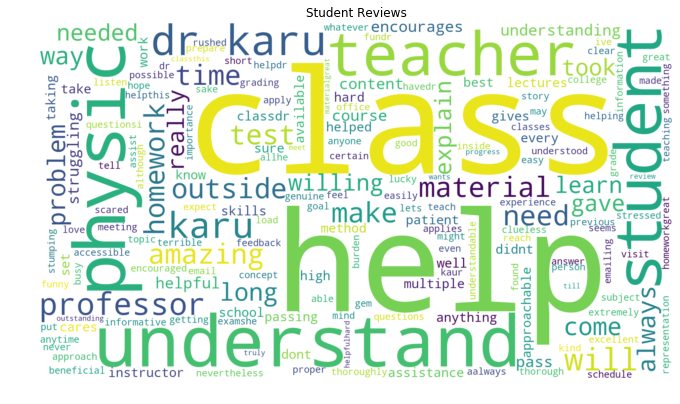

In [0]:
f = plt.figure(figsize = (25,25))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title('Student Reviews')
plt.axis("off")
plt.show()